# Hierarchical Aircraft Satisfaction Model

Which aircraft do customers prefer?  

In [3]:
import sys
import os
import pandas as pd  #General data analysis package for python
import pymc3 as mc   #Bayesian modeling package with state-of-the-art MCMC samplers
import numpy as np   
import matplotlib.pyplot as plt  #Visualization packages
import seaborn as sns


%matplotlib inline

In [4]:
cwd = os.getcwd()
datadir  = os.path.join(cwd, '../data')
infile = os.path.join(datadir, 'sample.csv')
df = pd.read_csv(infile)
n_rows = float(df.shape[0])
n_cols = float(df.shape[0])
print("Opened %s with size (%f, %f)" % (infile, n_rows, n_cols))
var = 'gts_1'

Opened /home/kcavagnolo/delta/py_models/../data/sample.csv with size (54751.000000, 54751.000000)


Define some utility functions for converting survey results to NPS or other targets

In [26]:
def promoter(row):
    if row[var] == 5:
        return 1.0
    elif row[var] <= 4:
        return 0.0 
    else:
        return -1.0   ##Results in NAs being removed from data    
    
    
def detractor(row):
    if row[var] >=4 :
        return 0.0
    elif row[var] <= 3:
        return 1.0 
    else:
        return -1.0   ##Results in NAs being removed from data
    
def nps(row):
    if row[var] == 5:
        return 1.0
    elif row[var] <= 3:
        return -1.0 
    else:
        return 0.0
    
df['detractor']= df.apply(detractor, axis=1)
df['promoter'] = df.apply(promoter, axis=1)
df['nps'] = df.apply(nps,axis=1)
df2 = df[df.detractor >= 0]
gb = df2.groupby('PFL_FLEET_TYP_CD')['detractor', 'promoter']  #Aggregate the data to plane-level
df3 = gb.agg([ len, np.sum, np.mean])
df3

detractor                 promoter                
                       len   sum      mean      len   sum      mean
PFL_FLEET_TYP_CD                                                   
319                   2564   444  0.173167     2564  1125  0.438768
320                   4007   732  0.182680     4007  1693  0.422511
332                    260    68  0.261538      260    92  0.353846
333                    657   167  0.254186      657   230  0.350076
717                   1904   318  0.167017     1904   875  0.459559
738                   3479   734  0.210980     3479  1375  0.395229
739                   1986   376  0.189325     1986   833  0.419436
73W                    333    54  0.162162      333   148  0.444444
744                    421   126  0.299287      421   128  0.304038
753                   1300   268  0.206154     1300   505  0.388462
757                   8243  1791  0.217275     8243  3322  0.403009
763                   1230   273  0.221951     1230   447  0.363415
764                    601   134  0.222962      601   204  0.339434
76G                    773   174  0.225097      773   278  0.359638
76L                    897   204  0.227425      897   337  0.375697
772                    218    58  0.266055      218    71  0.325688
77L                    307    81  0.263844      307   106  0.345277
CPJ                      1     0  0.000000        1     0  0.000000
CR2                      1     1  1.000000        1     0  0.000000
CR7                   2278   441  0.193591     2278   978  0.429324
CR9                   3895   763  0.195892     3895  1607  0.412580
CRJ                   4035   775  0.192069     4035  1713  0.424535
D95                      3     1  0.333333        3     1  0.333333
E70                    530    92  0.173585      530   233  0.439623
E75                   1470   275  0.187075     1470   645  0.438776
EC5                      3     0  0.000000        3     1  0.333333
ERJ                    762   174  0.228346      762   287  0.376640
M90                   4719   844  0.178851     4719  2007  0.425302
MD8                   7402  1355  0.183059     7402  3235  0.437044

In [29]:
n_obs = df.shape[0]-1
customers = np.array(df3['detractor']['len'])
detractors = np.array(df3['detractor']['sum'])
promoters = np.array(df3['promoter']['sum'])
neutral = customers - detractors - promoters
net_promoters = promoters-detractors
data=np.transpose([detractors, promoters, neutral]).astype(int)
data = [detractors, promoters, neutral]
data= np.asarray(data).astype(int)

## Net Promoter Model 

In [7]:
c = customers[np.where(net_promoters >=0)]
npr = net_promoters[np.where(net_promoters >=0)]
names = df3.index[np.where(net_promoters >= 0)]
with mc.Model() as model:
    
    mu_np = mc.Beta('mu_np', 2, 2)
    kappa_np = mc.Gamma('kappa_np', 1, 0.1) 
    
    theta_np= mc.Beta('aircraft_nps', alpha=mu_np*kappa_np , beta=(1-mu_np)*kappa_np, shape=28 )
    
    likelihood = mc.Binomial('likelihood', n= c, p = theta_np, observed = npr )
        
    start = mc.find_MAP()  # find a reasonable starting point.
    step1 = mc.Metropolis([theta_np, mu_np, kappa_np])
    step2 = mc.NUTS([kappa_np])
    
    trace= mc.sample(10000, [step1, step2], start=start, random_seed=(123), progressbar=False)    

Applied logodds-transform to mu_np and added transformed mu_np_logodds to model.
Applied log-transform to kappa_np and added transformed kappa_np_log to model.
Applied logodds-transform to aircraft_nps and added transformed aircraft_nps_logodds to model.


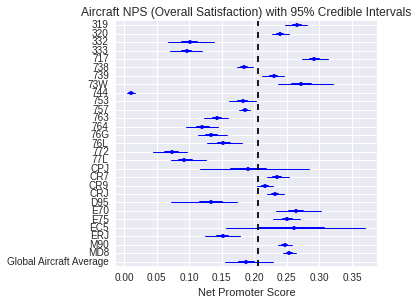

In [9]:
labels = np.append(names, "Global Aircraft Average")

mc.forestplot(trace, vars=['aircraft_nps','mu_np'],
              main="Aircraft NPS (Overall Satisfaction) with 95% Credible Intervals",
              ylabels=labels.tolist(),
              vline=.205,
              xtitle="Net Promoter Score",
              chain_spacing = 10)

In [13]:
burn = 5000
lb = np.empty(28)
ub = np.empty(28)
means = np.empty(28)
for i in range(0,28):
    lb[i] = np.percentile(a=trace['aircraft_nps'][burn:,i]*100, q=2.5).astype(int)
    means[i] =  (np.mean(trace['aircraft_nps'][burn:,i])*100).astype(int)
    ub[i] = np.percentile(a=trace['aircraft_nps'][burn:,i]*100, q=97.5).astype(int)

## Model 2: Dissatisfaction Model

Applied logodds-transform to mu and added transformed mu_logodds to model.
Applied log-transform to kappa and added transformed kappa_log to model.
Applied logodds-transform to detractor_rate and added transformed detractor_rate_logodds to model.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5f9688d90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd5e7f9c090>]], dtype=object)

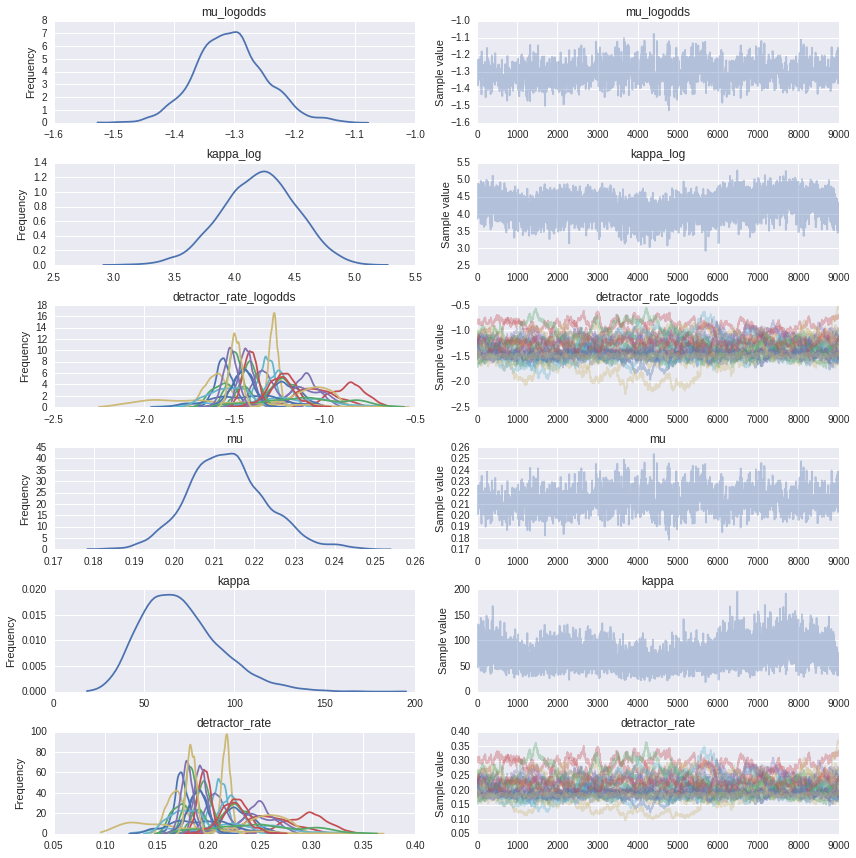

In [14]:
with mc.Model() as hierarchical_model:
    
    #Hyperparameters
    mu = mc.Beta('mu', 2, 2)
    kappa = mc.Gamma('kappa', 1, 0.1)
    
    #This represents a separate average for each--each player's average comes from the global parameters
    theta = mc.Beta('detractor_rate',alpha = mu*kappa, beta = (1-mu)*kappa, shape= n_obs)
    
    #Define the likelihood
    d = mc.Binomial('d', n=customers, p=theta,  observed=detractors)
    
    #   Generate a MCMC chain
    start = mc.find_MAP()  # find a reasonable starting point.
    step1 = mc.Metropolis([theta, mu, kappa])
    step2 = mc.NUTS([kappa])
    trace_hierarchical = mc.sample(10000, [step1, step2], start=start, random_seed=(123), progressbar=False)
    
burn=1000
mc.traceplot(trace_hierarchical[burn:])    

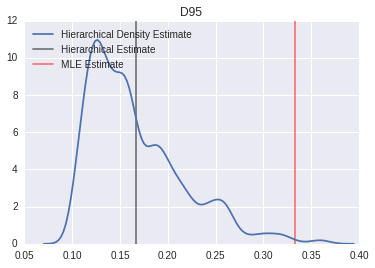

In [19]:
i=22
aircraft_trace = trace_hierarchical['detractor_rate'][1000:,i]

sns.kdeplot(aircraft_trace, label='Hierarchical Density Estimate')
plt.title("%s" %df3.index[i])
plt.vlines(x=np.mean(aircraft_trace), ymin=plt.ylim()[0],ymax=plt.ylim()[1],label='Hierarchical Estimate', alpha=.5)
#plt.vlines(x=df.RemainingAverage[i], ymin=plt.ylim()[0],ymax=plt.ylim()[1], label = 'Remaining Average (Target)', alpha = .8, color='green') 
plt.vlines(x=df3['detractor']['mean'][i], ymin=plt.ylim()[0],ymax=plt.ylim()[1], label = 'MLE Estimate', color='red',alpha = .5)
plt.legend(loc='upper left')

This is for one player.  What happens when we compare the squared error of the predictions for all the players?  The mean-squared error (MSE) for the Hierarchical model is less than half of the MSE.  

ValueError: x and y must be the same size

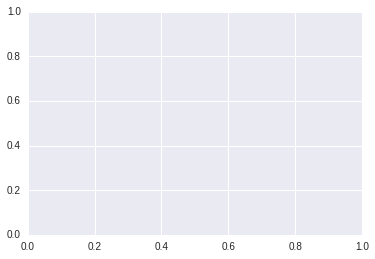

In [35]:
shrunken_estimate = np.empty(n_obs)

for i in range(0,28):
    shrunken_estimate[i] = np.mean(trace_hierarchical['detractor_rate'][burn:,i])

plt.scatter(x=range(0,28), y=(shrunken_estimate), color='red', label='Shrunken Estimate')
plt.scatter(x=range(0,28), y=(df3['detractor']['mean']), color='gray', label='MLE Estimate')
plt.hlines(y=.434, xmin=0,xmax=18, label="True Prediction Line")
plt.legend(bbox_to_anchor=(1.5, .525))
plt.autoscale(tight=True)
plt.title("Estimates of Detractor Rates")

## Model 3: Categorical Model

In [36]:
customers = np.asarray([100, 50, 40])
data = np.asarray([[80,10,10], [40,5,5], [10,20,10]])

with mc.Model() as model3:
    #Hyperparameters
    mu = mc.Beta('mu', .5, .5)
    kappa = mc.Gamma('kappa', 1, 0.1)
    
    
    theta_1 = mc.Beta('theta_1',alpha = mu*kappa, beta = (1-mu)*kappa, shape= n_obs)    
    theta_2 = mc.Uniform('theta_2', lower=0, upper = 1-theta_1, shape=n_obs)
    nps = mc.Deterministic('nps', theta_1-theta_2)
    
    probs = [theta_1, theta_2, 1-theta_1-theta_2]
    
    likelihood = mc.Multinomial('likelihood',  n=customers, p=probs, observed= data)
    
        
    start = mc.find_MAP(fmin=optimize.fmin_powell)  
    step1 = mc.Metropolis([theta_1, theta_2, nps, mu, kappa])
    step2 = mc.NUTS([kappa])
    trace = mc.sample(100, [step1], start=start, random_seed=(123), progressbar=False)

### RAGE QUIT!!

Applied logodds-transform to mu and added transformed mu_logodds to model.
Applied log-transform to kappa and added transformed kappa_log to model.
Applied logodds-transform to theta_1 and added transformed theta_1_logodds to model.
Applied interval-transform to theta_2 and added transformed theta_2_interval to model.


AsTensorError: ('Cannot convert [Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0] to TensorType', <type 'numpy.ndarray'>)